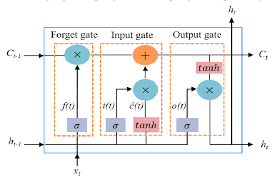

In [1]:
import torch
import torch.nn as nn
import numpy as np

In [2]:
class SimpleLSTM(nn.Module):
    """Minimal LSTM implementation to understand the core concept."""

    def __init__(self, input_size, hidden_size):
        super(SimpleLSTM, self).__init__()
        self.hidden_size = hidden_size

        # Combined weight matrix for all gates (more efficient)
        # Contains: [forget, input, candidate, output] gates
        self.weight_ih = nn.Linear(input_size, 4 * hidden_size)  # input to hidden
        self.weight_hh = nn.Linear(hidden_size, 4 * hidden_size)  # hidden to hidden

    def forward(self, x, hidden=None):
        """
        x: (batch_size, seq_length, input_size)
        hidden: tuple of (h, c) or None
        """
        batch_size, seq_length, _ = x.size()

        # Initialize hidden state and cell state
        if hidden is None:
            h = torch.zeros(batch_size, self.hidden_size)
            c = torch.zeros(batch_size, self.hidden_size)
        else:
            h, c = hidden

        outputs = []

        # Process sequence step by step
        for t in range(seq_length):
            x_t = x[:, t, :]  # Get input at time t

            # Compute all gates at once
            gates = self.weight_ih(x_t) + self.weight_hh(h)

            # Split into 4 gates
            f_gate, i_gate, c_gate, o_gate = gates.chunk(4, dim=1)

            # Apply activations
            f_gate = torch.sigmoid(f_gate)  # Forget gate
            i_gate = torch.sigmoid(i_gate)  # Input gate
            c_gate = torch.tanh(c_gate)     # Candidate cell state
            o_gate = torch.sigmoid(o_gate)  # Output gate

            # Update cell state
            c = f_gate * c + i_gate * c_gate

            # Update hidden state
            h = o_gate * torch.tanh(c)

            outputs.append(h)

        # Stack all outputs
        output = torch.stack(outputs, dim=1)  # (batch_size, seq_length, hidden_size)

        return output, (h, c)    # ouput ha all the h states , and (h,c)-> the last hidden and cell state.

In [3]:
class LSTMClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(LSTMClassifier, self).__init__()
        self.lstm = SimpleLSTM(input_size, hidden_size)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        # Get LSTM output
        lstm_out, (h_final, c_final) = self.lstm(x)

        # Use final hidden state for classification
        output = self.fc(h_final)
        return output

In [4]:

def generate_data(num_samples=100, seq_length=100):
    """Generate simple sequences for classification."""
    X = []
    y = []

    for _ in range(num_samples):
        if np.random.rand() > 0.5:
            # Increasing sequence
            seq = np.sort(np.random.randn(seq_length))
            label = 1
        else:
            # Decreasing sequence
            seq = np.sort(np.random.randn(seq_length))[::-1]
            label = 0

        X.append(seq.reshape(-1, 1))  # Shape: (seq_length, 1)
        y.append(label)

    return torch.FloatTensor(np.array(X)), torch.LongTensor(np.array(y))

In [5]:
print("Generating data...")
X_train, y_train = generate_data(num_samples=1000, seq_length=10)
X_test, y_test = generate_data(num_samples=200, seq_length=10)

print(f"Training data shape: {X_train.shape}")
print(f"Training labels shape: {y_train.shape}")

# Create model
model = LSTMClassifier(input_size=1, hidden_size=20, num_classes=2)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Training loop
print("\nTraining...")
num_epochs = 30
batch_size = 32

for epoch in range(num_epochs):
    # Simple batching
    indices = torch.randperm(len(X_train))

    epoch_loss = 0
    correct = 0
    total = 0

    for i in range(0, len(X_train), batch_size):
        batch_indices = indices[i:i+batch_size]
        batch_X = X_train[batch_indices]
        batch_y = y_train[batch_indices]

        # Forward pass
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Calculate accuracy
        _, predicted = torch.max(outputs, 1)
        total += batch_y.size(0)
        correct += (predicted == batch_y).sum().item()
        epoch_loss += loss.item()

    # Print progress every 5 epochs
    if (epoch + 1) % 5 == 0:
        accuracy = 100 * correct / total
        avg_loss = epoch_loss / (len(X_train) // batch_size)
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}%')

Generating data...
Training data shape: torch.Size([1000, 10, 1])
Training labels shape: torch.Size([1000])

Training...
Epoch [5/30], Loss: 0.0006, Accuracy: 100.00%
Epoch [10/30], Loss: 0.0003, Accuracy: 100.00%
Epoch [15/30], Loss: 0.0002, Accuracy: 100.00%
Epoch [20/30], Loss: 0.0001, Accuracy: 100.00%
Epoch [25/30], Loss: 0.0001, Accuracy: 100.00%
Epoch [30/30], Loss: 0.0000, Accuracy: 100.00%


In [7]:
# Test the model
print("\nTesting...")
model.eval()
with torch.no_grad():
    test_outputs = model(X_test)
    _, predicted = torch.max(test_outputs, 1)
    test_accuracy = 100 * (predicted == y_test).sum().item() / len(y_test)
    print(f'Test Accuracy: {test_accuracy:.2f}%')

# Example prediction
print("\n" + "="*60)
print("EXAMPLE PREDICTIONS")
print("="*60)

with torch.no_grad():
    # Test on a few examples
    for i in range(3):
        example = X_test[i:i+1]
        label = y_test[i].item()
        output = model(example)
        _, pred = torch.max(output, 1)

        print(f"\nSequence {i+1}: {example.squeeze().numpy().flatten()[:5]}... ")
        print(f"True label: {'Increasing' if label == 1 else 'Decreasing'}")
        print(f"Predicted: {'Increasing' if pred.item() == 1 else 'Decreasing'}")
        print(f"Confidence: {torch.softmax(output, dim=1).max().item():.2%}")


Testing...
Test Accuracy: 100.00%

EXAMPLE PREDICTIONS

Sequence 1: [-0.94860584 -0.78857666 -0.22524212 -0.05221995  0.1620921 ]... 
True label: Increasing
Predicted: Increasing
Confidence: 99.99%

Sequence 2: [-2.4404335 -2.335303  -1.0011495 -0.9816484 -0.7903641]... 
True label: Increasing
Predicted: Increasing
Confidence: 99.99%

Sequence 3: [ 2.530491    1.7420883   0.59598255  0.58279306 -0.08731031]... 
True label: Decreasing
Predicted: Decreasing
Confidence: 100.00%
